In [2]:
#Using our synthetic data library for today's exercise
#pip install ydata

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#Loading the census dataset from kaggle
import logging
import os
import requests
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
#import ydata.synthetic.regular as synthetic

#Dataset URL from kaggle
data_url = 'https://www.kaggle.com/uciml/adult-census-income/downloads/adult.csv'

# The local path where the data set is saved.
local_filename = "adult.csv"

# Kaggle Username and Password
kaggle_info = {'UserName': "myusername", 'Password': "mypassword"}

# Attempts to download the CSV file. Gets rejected because we are not logged in.
r = requests.get(data_url)

# Login to Kaggle and retrieve the data.
r = requests.post(r.url, data = kaggle_info)

# Writes the data to a local file one chunk at a time.
f = open(local_filename, 'wb')
for chunk in r.iter_content(chunk_size = 512 * 1024): # Reads 512KB at a time into memory

    if chunk: # filter out keep-alive new chunks
        f.write(chunk)
f.close()

In [15]:
adult_census = pd.read_csv('adult.csv')

#For the purpose of this exercise we will filter information regarding only black and white individuals. 
adult_census = adult_census[(adult_census['race']=='White') | (adult_census['race']=='Black')]

income = adult_census['income']
adult_census = adult_census.drop('education.num', axis=1)
adult_census = adult_census.drop('income', axis=1)

train_adult, test_adult, income_train, income_test = train_test_split(adult_census, income, test_size=0.33, random_state=42)

train_adult['income'] = income_train

train_adult.head(10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,age,workclass,fnlwgt,education,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
21805,51,Local-gov,182985,HS-grad,Married-civ-spouse,Adm-clerical,Wife,White,Female,0,0,40,United-States,<=50K
18711,37,Self-emp-not-inc,265266,Prof-school,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,Cuba,>50K
4477,25,Private,371987,Bachelors,Never-married,Exec-managerial,Not-in-family,White,Female,0,0,40,United-States,<=50K
6107,42,Private,169995,HS-grad,Married-civ-spouse,Sales,Husband,White,Male,0,0,48,United-States,<=50K
23638,38,Private,301743,HS-grad,Divorced,Other-service,Not-in-family,White,Female,0,0,35,United-States,<=50K
29460,40,Federal-gov,178866,HS-grad,Married-civ-spouse,Adm-clerical,Wife,White,Female,0,0,20,United-States,>50K
21416,40,Private,233320,7th-8th,Separated,Other-service,Not-in-family,White,Female,0,0,25,United-States,<=50K
25505,40,Federal-gov,196456,Some-college,Never-married,Adm-clerical,Own-child,White,Female,0,0,40,United-States,<=50K
12214,42,Private,106900,Assoc-voc,Never-married,Tech-support,Not-in-family,White,Male,0,0,40,United-States,<=50K
20782,29,Private,232666,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,<=50K


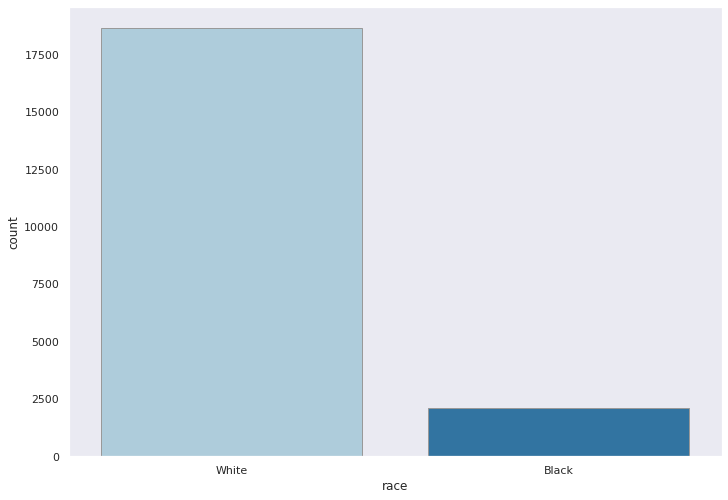

In [16]:
sns.set(style="dark", rc={'figure.figsize':(11.7,8.27)})

sns.countplot(x="race",
              palette="Paired", edgecolor=".6",
              data=train_adult)

In [17]:
#Let's tackling the bias present in the dataset.
#For that purpose we will need to filter the records belonging to only the black individuals. 
def filter_fn(row):
    if row['race'] == 'Black':
        return True
    else:
        return False

filt = train_adult.apply(filter_fn, axis=1)
train_adult_black = train_adult[filt]

Number of records belonging to black individuals: 2097


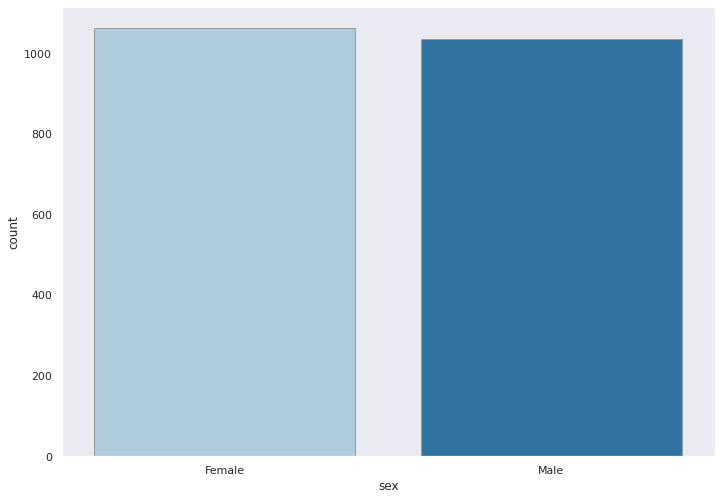

In [18]:
print("Number of records belonging to black individuals: {}".format(train_adult_black.shape[0]))

sns.set(style="dark", rc={'figure.figsize':(11.7,8.27)})

sns.countplot(x="sex",
              palette="Paired", edgecolor=".6",
              data=train_adult_black)
#In what concerns sex, we have an equal representation of women and man for the black population of the dataset

In [19]:
#Using the YData synthetic data lib to generate new 3000 individuals for the black population
synth_model = synthetic.SynthTabular()
synth_model.fit(adult_black)

synth_data = synth_model.sample(n_samples=3000)

"\nsynth_model = synthetic.SynthTabular()\nsynth_model.fit(adult_black)\n\nsynth_data = synth_model.sample(n_samples=1000)\n\nsynth_data.to_csv('synth_data.csv')\n"

In [72]:
synth_data = pd.read_csv('synth_data.csv', index_col=[0])
synth_data = synth_data.drop('education.num', axis=1)

synth_data = pd.concat([synth_data[synth_data['income']=='>50K'],synth_data[synth_data['income']=='<=50K'][:1000]])
synth_data.describe()

,age,fnlwgt,capital.gain,capital.loss,hours.per.week
count,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000
mean,39.970496,251363.940364,353.072191,46.891400,41.369115
std,12.689261,122172.483784,1846.854989,281.143931,10.563726
min,15.000000,19721.000000,0.000000,0.000000,12.000000
25%,31.000000,164358.000000,0.000000,0.000000,40.000000
50%,39.000000,225974.000000,0.000000,0.000000,40.000000
75%,48.000000,320165.000000,10.000000,1.000000,47.000000
max,95.000000,809913.000000,17523.000000,2042.000000,98.000000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


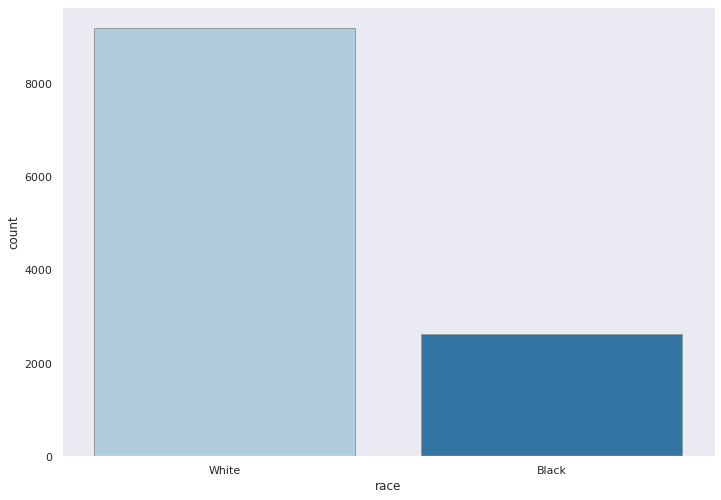

In [73]:
#Now combining both the datasets
test_adult['income'] = income_test
adult_combined = synth_data.append(test_adult).sample(frac=1)

#Let's check again how are we regarding the balancing of our classes for the race variable
sns.set(style="dark", rc={'figure.figsize':(11.7,8.27)})

sns.countplot(x="race",
              palette="Paired", edgecolor=".6",
              data=adult_combined)

In [74]:
#Auxiliar function to encode the categorical variables
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score, average_precision_score

def numerical_encoding(df, cat_cols=[], ord_cols=[]):
    try:
        assert isinstance(df, pd.DataFrame)
    except AssertionError as e:
        logging.error('The df input object must a Pandas dataframe. This action will not be executed.')
        return
    ord_cols_val = None
    cat_cols_val = None
    dummies = None
    cont_cols = list(set(df.columns) - set(cat_cols+ord_cols))
    cont_vals = df[cont_cols].values

    if len(ord_cols) > 0:
        ord_cols_val = df[ord_cols].values
        label_encoder = LabelEncoder
        ord_encoded = label_encoder.fit_transform(ord_cols_val)

    if len(cat_cols) > 0:
        cat_cols_val = df[cat_cols].values
        hot_encoder = OneHotEncoder()
        cat_encoded = hot_encoder.fit_transform(cat_cols_val).toarray()

        dummies = []
        for i, cat in enumerate(hot_encoder.categories_):
            for j in cat:
                dummies.append(cat_cols[i]+'_'+str(j))

    if ord_cols_val is not None and cat_cols_val is not None:
        encoded = np.hstack([cont_vals, ord_encoded, cat_encoded])
        columns = cont_cols+ord_cols+dummies
    elif cat_cols_val is not None:
        encoded = np.hstack([cont_vals, cat_encoded])
        columns = cont_cols+ord_cols+dummies
    else:
        encoded = cont_vals
        columns = cont_cols

    return pd.DataFrame(encoded, columns=columns), dummies

In [75]:
#validation functions
def score_estimators(estimators, x_test, y_test):

    #f1_score average='micro'
    scores = {type(clf).__name__: f1_score(y_test, clf.predict(x_test), average='micro') for clf in estimators}

    return scores


def fit_estimators(estimators, data_train, y_train):
    estimators_fit = []
    for i, estimator in enumerate(estimators):
        estimators_fit.append(estimator.fit(data_train, y_train))
    return estimators_fit

def estimator_eval(data, y, cat_cols=[]):
  def order_cols(df):
    cols = sorted(df.columns.tolist())
    return df[cols]

  data,_ = numerical_encoding(data, cat_cols=cat_cols)

  y, uniques = pd.factorize(y)
  data = order_cols(data)

  x_train, x_test, y_train, y_test = train_test_split(data, y, test_size=0.33, random_state=42)

  # Prepare train and test datasets
  estimators = [
                LogisticRegression(multi_class='auto', solver='lbfgs', max_iter=500, random_state=42),
                RandomForestClassifier(n_estimators=10, random_state=42),
                DecisionTreeClassifier(random_state=42),
                SVC(gamma='auto'),
                KNeighborsClassifier(n_neighbors=5)
            ]	
 
  estimators_names = [type(clf).__name__ for clf in estimators]

  for estimator in estimators:
    assert hasattr(estimator, 'fit')
    assert hasattr(estimator, 'score')

  estimators = fit_estimators(estimators, x_train, y_train) 
  scores = score_estimators(estimators, x_test, y_test)

  return scores

In [76]:
real_scores = estimator_eval(data=test_adult.drop('income', axis=1),
                            y=test_adult['income'], 
                            cat_cols=['workclass', 'education', 'marital.status', 'occupation', 'relationship','race', 'sex', 'native.country'])

synth_scores = estimator_eval(data=adult_combined.drop('income', axis=1),
                              y=adult_combined['income'], 
                              cat_cols=['workclass', 'education', 'marital.status', 'occupation', 'relationship','race', 'sex', 'native.country'])

In [ ]:
dict_results = {'original': real_scores, 'synthetic': synth_scores}
results = pd.DataFrame(dict_results).reset_index()

print("Mean average accuracy improvement: {}".format((results['synthetic'] - results['original']).mean()))

results_graph = results.melt('index', var_name='data_source', value_name='accuracy')

Mean average accuracy improvement: 0.024448394946566386


In [ ]:
 pd.DataFrame(dict_results).transpose()

,LogisticRegression,RandomForestClassifier,DecisionTreeClassifier,SVC,KNeighborsClassifier
original,0.791941,0.834173,0.805114,0.734986,0.753584
synthetic,0.810818,0.851320,0.816201,0.779287,0.784414


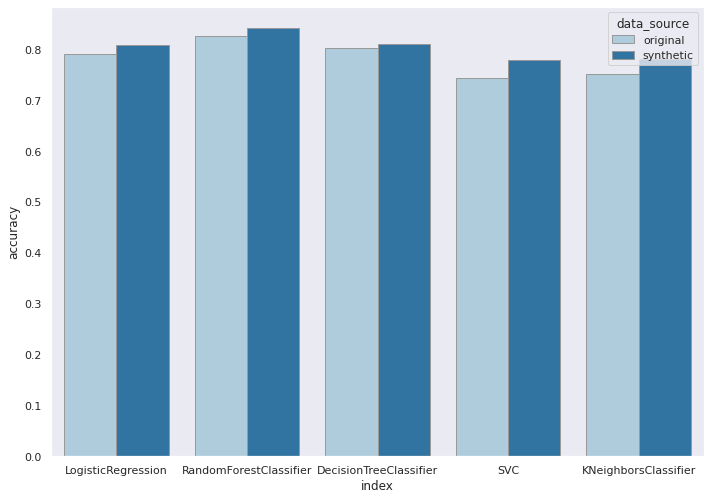

In [ ]:
#Final results comparision

sns.barplot(x="index", y="accuracy", hue="data_source", data=results_graph, 
            palette="Paired", edgecolor=".6")